<a href="https://colab.research.google.com/github/olgaminguett/CE6003/blob/master/Etivity_assignment1_OlgaMinguett_20179766.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Etivity Assignment 1: Ships in Satellite Imagery
In this assignment we will build & train an object detector to solve the problem of idenifying ships in satellite imagery. 

![link text](https://github.com/tonyscan6003/CE6003/blob/master/images/sat_img1.JPG?raw=true)

This assignment demonstrates that classical image processing techniques may be used in preference to deep learning for certain applications. Particularly those that are limited in computational power or require fast execution. 



This lab uses a [kaggle dataset](https://www.kaggle.com/rhammell/ships-in-satellite-imagery). Please read the [PDF](https://github.com/tonyscan6003/CE6003/blob/master/images/CE6003_kaggle_data_instructions.pdf) detailing how to setup your PC so that you can use a kaggle dataset within Colab.  The dataset contains image patches of ships as well as background images of sea and coastline. 

![Ships in Satellite imagery](https://i.imgur.com/tLsSoTz.png)

This assigment contains all the code necessary to read the downloaded kaggle files and create image and label arrays with test and train splits.




# Dowload Kaggle Dataset.
The following code cells will download the kaggle ship-in-satellite-imagery dataset and unzip the file. (Ensure you have a valid kaggle API token stored on your PC as described in the PDF.)

In [1]:
# Use this only if have problems with stale .json file
!rm kaggle.json
!rm ~/.kaggle/kaggle.*

In [2]:
!pip install -q kaggle==1.5.6
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"olgaminguett","key":"8188738cf4e4212c7c9e1a9674294236"}'}

In [3]:
#Choose the kaggle.json file that you downloaded
! mkdir ~/.kaggle
#Make directory named kaggle and copy kaggle.json file there.
! cp kaggle.json ~/.kaggle/
#Change the permissions of the file.
!chmod 600 ~/.kaggle/kaggle.json

# Load dataset
!kaggle datasets download rhammell/ships-in-satellite-imagery

!unzip ships-in-satellite-imagery.zip > /dev/null

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ships-in-satellite-imagery.zip: Skipping, found more recently modified local copy (use --force to force download)
replace scenes/scenes/lb_1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


#HouseKeeping
 Import packages, helper functions to read from URL and import images.

In [4]:
import glob
import cv2

import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from skimage import feature
from skimage import exposure
from sklearn import svm
from sklearn.model_selection import train_test_split

def url_to_image(url):
  	resp = urllib.request.urlopen(url)
  	temp_image = np.asarray(bytearray(resp.read()), dtype="uint8")
  	temp_image = cv2.imdecode(temp_image, cv2.IMREAD_COLOR)
  	temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB) # OpenCV defaults to BGR, but we need RGB here..
  	return temp_image


def read_image(image_url):
    image = url_to_image(image_url)
    x,y,z = np.shape(image)
    # Image is scaled to reduce computation time
    image = cv2.resize(image, dsize=(int(y/sf), int(x/sf)), interpolation=cv2.INTER_CUBIC)
    return image

In [5]:
# Read downloaded file list: Files are comprised of positive (ship) and negaitive (Not ship) examples
pos_img_list = glob.glob('shipsnet/shipsnet/1_*.png')
neg_img_list = glob.glob('shipsnet/shipsnet/0_*.png')
print(np.shape(pos_img_list))
print(np.shape(neg_img_list))

(1000,)
(3000,)


# Read Data 
Read data from unzipped downloaded files and create the Training and Test sets. (Note that these are training and test sets of image patches that can be used to train an image classifier)

In [6]:
# Set variables
n = 80 # number of x,y pixels in this image.
n_pts = 4000 # number of points to use (are 4000 in dataset, 1000 positive 3000 negative)

In [7]:
def read_images(img_list):
   train_pos = np.empty([1,n*n])
   # Function to read images from file list 
   for i in range(len(img_list)): 
      img_path = img_list[i]
      img = cv2.imread(img_path, cv2.IMREAD_COLOR)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      #  store image as row in array
      train_pos = (np.concatenate((train_pos,np.reshape(img, (1, n*n)))) if i>0 else  np.reshape(img, (1, n*n)))
   return train_pos 

In [8]:
# Read positive and negative shp images into arrays 
pos_img = read_images(pos_img_list)
neg_img = read_images(neg_img_list)

In [9]:
# create corresponding arrays of labels
y_pos_labels = np.ones(len(pos_img_list))
y_neg_labels = np.zeros(len(neg_img_list))

In [10]:
# Combine positive and negative images into one dataset. 
dataset_img = np.concatenate((pos_img[0:1000,:],neg_img[0:3000,:]))
dataset_labels = np.append(y_pos_labels,y_neg_labels)

In [11]:
# Training examples
n_train = int(0.7*n_pts)

# Divide into training and test sets with labels
X_train, X_test, y_train, y_test = train_test_split(dataset_img, dataset_labels, 
                                                    train_size=n_train,
                                                    random_state=0,
                                                    stratify=dataset_labels)

In [12]:
print ("X_train shape: ", X_train.shape)
print ("X_test shape: ", X_test.shape)

X_train shape:  (2800, 6400)
X_test shape:  (1200, 6400)


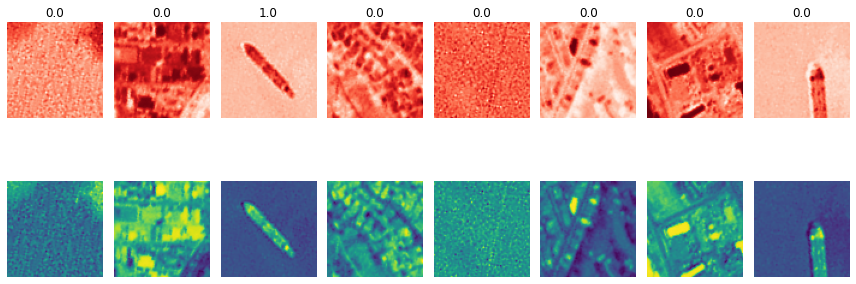

In [13]:
n_plots = 8 # number of plots
f, (ax1, ax2) = plt.subplots(2,n_plots,figsize=(12,6))
for i in range(0,n_plots,1):
   ax1[i].title.set_text(y_train[i])
   ax1[i].axis('off')
   ax1[i].imshow( np.reshape(X_train[i,0:n*n], (n, n)),'Reds')
   ax2[i].imshow( np.reshape(X_train[i,0:n*n], (n, n)))
   ax2[i].axis('off')
   plt.tight_layout()

#Part 2. Build and Train an Image Classifier
As we have seen in the notes simple object detectors are based on image classifiers trained on image patches. You must choose an appropriate representation for the images and a suitable classifier.

Hints:
> `feature.hog` command from [skimage](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html). 

>sklearn [list of classifiers](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)



## Your Work Here......
You can write code to train and test your image classifier in the code cell(s) below:

In [14]:
from skimage.feature import hog
from skimage import exposure

In [15]:
def hogging(image):
  '''
  Create HOG Descriptor function
  '''
  # extract Histogram of Oriented Gradients from the images
  fd, hog_image = hog(image, 
                      orientations=9,            #Number of orientation bins.
                      pixels_per_cell=(8, 8),    #Size (in pixels) of a cell.
                      cells_per_block=(2, 2),    #Number of cells in each block.
                      transform_sqrt=True,       #Apply power law compression to normalize the image before processing. 
                      block_norm="L2",           #Block normalization method. str {‘L1’, ‘L1-sqrt’, ‘L2’, ‘L2-Hys’}, optional
                      visualize=True)            #Returns an image of the HOG.  
  # Rescale histogram for better display
  hog_image = exposure.rescale_intensity(hog_image, out_range=(0, 255))
  hog_image = hog_image.astype("uint8")
  return fd, hog_image

In [16]:
 # Create Feature Descriptors for images patches
n = 80 # x, y pixel dimension
# Create descriptors for training images
hogfeatures_train = []
hogimages_train = []
for i in range(len(X_train)):
  image =  np.reshape(X_train[i,0:n*n], (n, n))
  fd, hog_image = hogging(image)
  hogfeatures_train.append(fd)
  hogimages_train.append(hog_image)

In [17]:
print("HOG Images Shape:", len(hogimages_train))
print("Single HOG Image Shape", hogimages_train[0].shape)

print("HOG Features Shape:", len(hogfeatures_train))
print("Single HOG Feature Shape:", hogfeatures_train[0].shape)

HOG Images Shape: 2800
Single HOG Image Shape (80, 80)
HOG Features Shape: 2800
Single HOG Feature Shape: (2916,)


Visualization of HOG Training Images


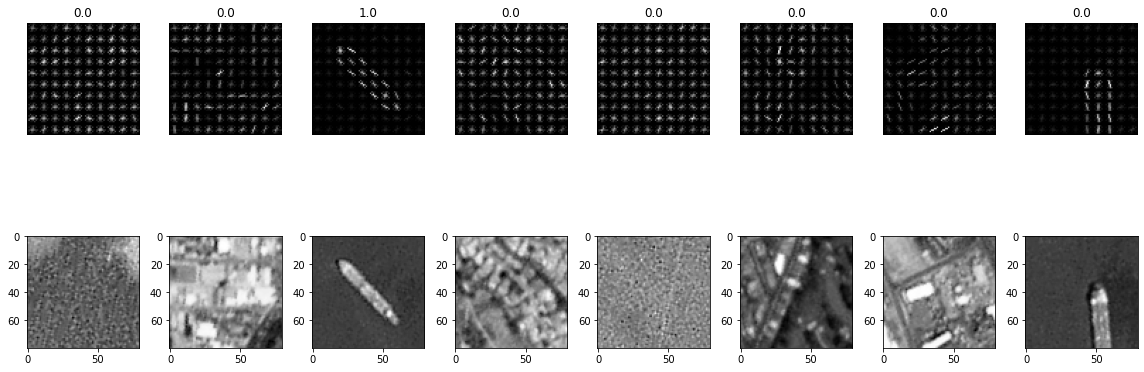

In [18]:
n_plots = 8 # number of plots
f, (ax1, ax2) = plt.subplots(2, n_plots, figsize=(16,8)) 

print("Visualization of HOG Training Images")
for i in range(0,n_plots,1):
   ax1[i].title.set_text(y_train[i])
   ax1[i].imshow(hogimages_train[i], 'gray')
   ax1[i].axis('off')
   ax2[i].imshow(np.reshape(X_train[i,0:n*n], (n, n)), 'gray')
   plt.tight_layout()

In [19]:
# Create Feature Descriptors for images patches
n = 80 # x, y pixel dimension
# Create descriptors for test images
hogfeatures_test = []
hogimages_test = []
for i in range(len(X_test)):
  image =  np.reshape(X_test[i,0:n*n], (n, n))
  fd, hog_image = hogging(image)
  hogfeatures_test.append(fd)
  hogimages_test.append(hog_image)

Visualization of HOG Test Images


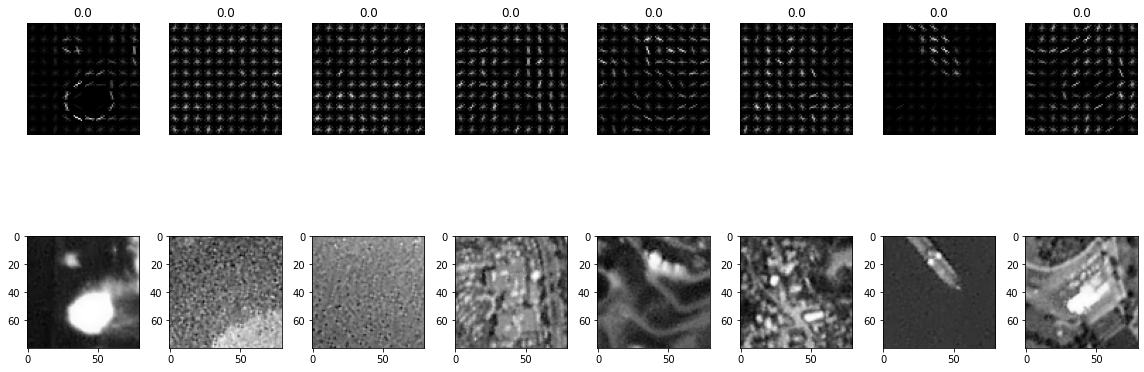

In [20]:
n_plots = 8 # number of plots
f, (ax1, ax2) = plt.subplots(2, n_plots, figsize=(16,8)) 

print("Visualization of HOG Test Images")
for i in range(0,n_plots,1):
   ax1[i].title.set_text(y_test[i])
   ax1[i].imshow(hogimages_test[i], 'gray')
   ax1[i].axis('off')
   ax2[i].imshow(np.reshape(X_test[i,0:n*n], (n, n)), 'gray')
   plt.tight_layout()

Test performance of your classifier using the test dataset and obtain a [classification report](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report).

You can plot some examples from the test set using the function in the cell below.  

Train the Model

In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [10, 1, 0.1, 0.01],  
    'gamma': [0.01, 0.1, 1, 10, 100], 
    'kernel': ['rbf', 'linear']}

search = GridSearchCV(svm.SVC(), param_grid, n_jobs=-1, cv=3, refit=True)
search.fit(hogfeatures_train, y_train)
# Print Results
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)
# best params and best model 
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_
# Retrain using best estimators
model = search.best_estimator_
model.fit(hogfeatures_train, y_train)
# Prediction evaluation
y_pred = model.predict(hogfeatures_test)

Best CV score = 0.988:
Best parameters:  {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


In [22]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'criterion': ["gini", "entropy"],  
    'max_features': ["auto", "sqrt", "log2"], 
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [10, 20, 30]}

search = GridSearchCV(RandomForestClassifier(), param_grid, n_jobs=-1, cv=3, refit=True)
search.fit(hogfeatures_train, y_train)
# Print Results
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)
# best params and best model 
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_
# Retrain using best estimators
model_rf = search.best_estimator_
model_rf.fit(hogfeatures_train, y_train)
# Prediction evaluation
y_pred_rf = model_rf.predict(hogfeatures_test)

Best CV score = 0.943:
Best parameters:  {'criterion': 'entropy', 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 30}


              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       900
         1.0       0.97      0.99      0.98       300

    accuracy                           0.99      1200
   macro avg       0.98      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



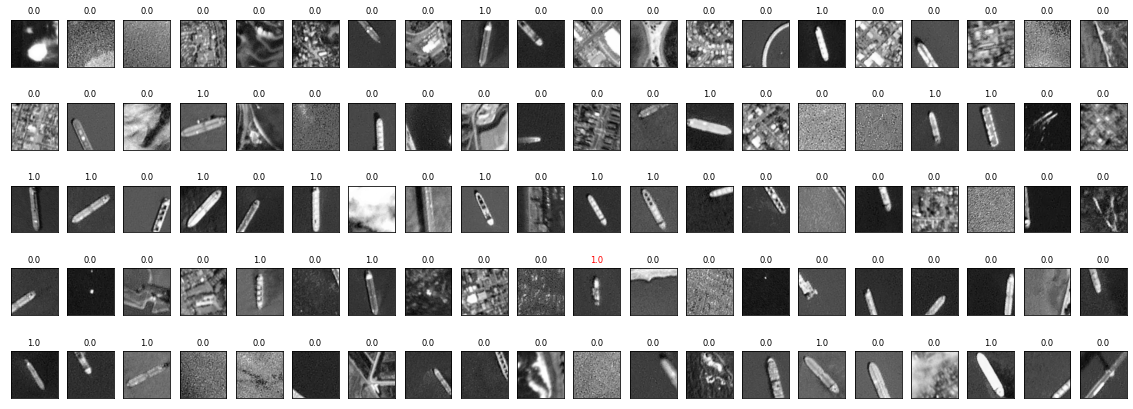

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

def plot_examples(y_pred,y_test):
   n_plots = 30 # number of plots
   fig = plt.figure(figsize=(20, 15))
   for i in range(100):
      ax = fig.add_subplot(10, 20, i + 1, xticks=[], yticks=[])
      ax.imshow( np.reshape(X_test[i,0:n*n], (n, n)) ,'gray')
      color = ('black' if y_pred[i] == y_test[i] else 'red')
      ax.set_title(y_test[i],
                 fontsize='small', color=color)
      
plot_examples(y_pred,y_test) 

# 2. Use the Classifier as a basic Object Detector 

**Import scene:** We want to use the classifier to perform object detection of ships in the high resolution satellite image scene imported in the code cell below. You can use grey scale version of the image gray_img in your detector, bounding boxes marking the locations of the ships can be applied to the colour version of the image.

*Coordinate Systems*

> The greyscale input image that we are applying our sliding window detector to is a matrix. The elements of this matrix are accessed as (row,column). In order to successfully plot the bouding box using OpenCV rectangle commands, the bounding boxes must be output in a format [x1,y1,x2,y2] where x1,y1 correspond to the top left hand side corner of the bouding box and x2,y2 the bottom right corner. Thus the x coordinate of the bounding box corresponds to the column of the matrix and the y coordinate the rows. The origin (0,0) in the coordinate system used by OpenCV is the top left of the image.

*Non Maximal Supression*

>  We can use the `non_max_supression` function from the `imutils` package to remove overlapping detections. (This is already implemented in a spearate code cell (see below) that displays the bouding boxes you find)  






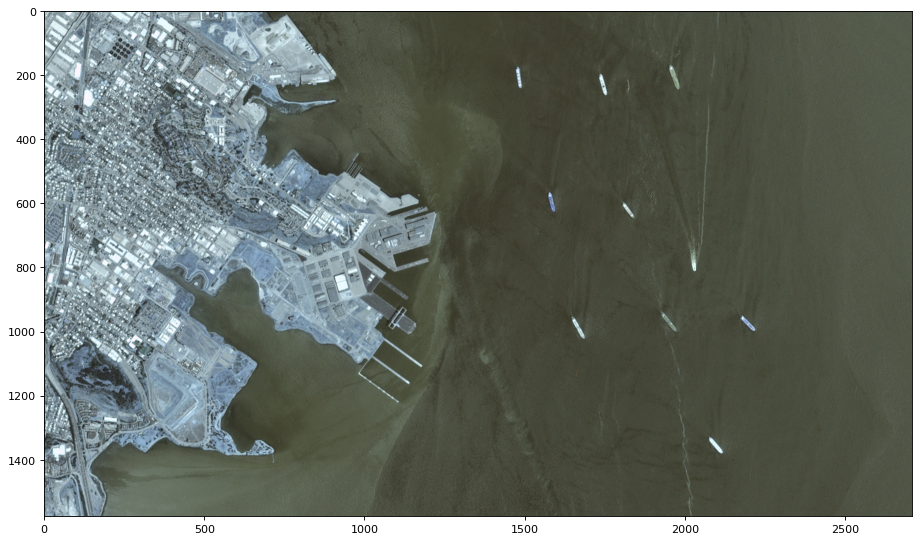

In [24]:
# Load and Display Secene to perform Object Detection on
img_path = 'scenes/scenes/sfbay_3.png'
col_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
gray_img = cv2.cvtColor(col_img, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(14, 10), dpi=80)
plt.imshow(col_img, aspect='auto') 
plt.imshow( col_img ,'gray');



## Your Work Here......
You can write code for the object detector that uses the classifier you previously developed in the code cell below:

The output of your object detector should be an array called "found_boxes" that is m x 4 array of output bounding boxes.
Each row corresponds to a bounding box [x1,y2,x2,y2] (see note on coordinate system above)








In [25]:
#   Sliding window is a rectangular region that slides across an image with a 
#   fixed width and height. In this case where the ships are found in the selected
#   image.

windowStep = 15
windowSize = 80

imageWidth = gray_img.shape[1]
imageHeight = gray_img.shape[0]

found_boxes_ = []
for x in range(0, imageHeight-windowSize, windowStep):
  for y in range(0, imageWidth-windowSize, windowStep):
    window = gray_img[x:x+windowSize, y:y+windowSize]
    # Create descriptor for image patch
    fd, hog_image = hogging(window)
    yt_pred = model.predict(fd.reshape((1,-1)))
    if yt_pred == 1:
      found_boxes_.append([y,x, y+windowSize, x+windowSize])

In [26]:
found_boxes = np.array(found_boxes_, dtype=np.float32)

The non_max_supression function from the imutils package can be used to remove overlapping boxes. The boxes are overlaid on the color version of the satellite image. The function operates on the "found boxes" vector that is output by your object detector.

The overlap threshold can be adjusted, this value determines how much overlap is required before detections are considered to be from the same object. (A high threshold will return more detections)  

Before suppression, we had 30 bounding boxes, after suppression we have 23


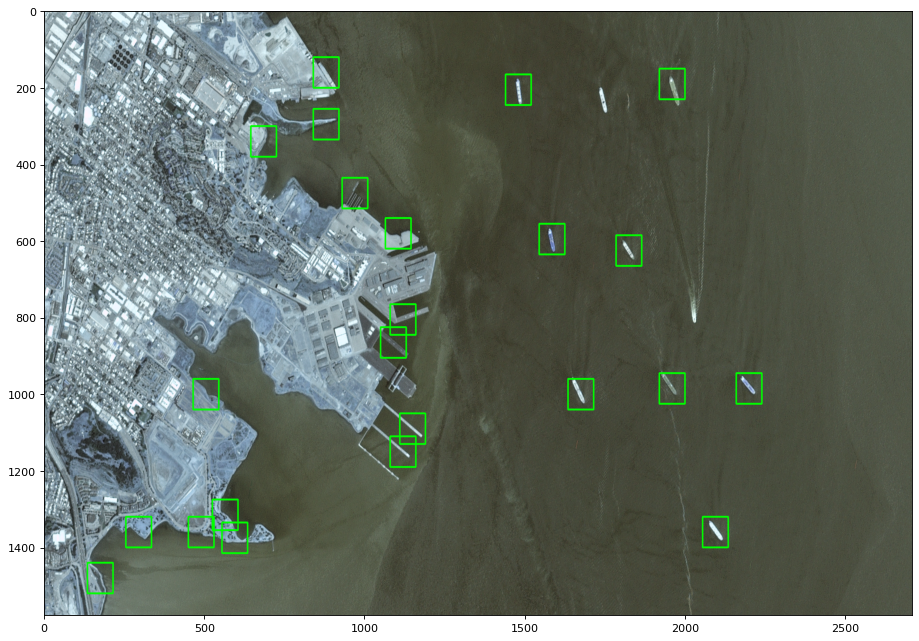

In [27]:
from imutils.object_detection import non_max_suppression

#Reload the colour image here to refresh, otherwise it will show old boxes
col_img = cv2.imread(img_path, cv2.IMREAD_COLOR)

#Bounding box parameters
greenColor = (0, 255, 0)
lineThickness = 4

# run non-max suppression on these based on an overlay op 25%
nmsBoundingBoxes = non_max_suppression(found_boxes, probs=None, overlapThresh=0.25)

print ("Before suppression, we had {} bounding boxes, after suppression we have {}".format(len(found_boxes), len(nmsBoundingBoxes)))

# draw the final bounding boxes
for (xA, yA, xB, yB) in nmsBoundingBoxes:
    cv2.rectangle(col_img, (xA, yA), (xB, yB), greenColor, lineThickness)

# Plot figures
plt.figure(figsize=(14, 10), dpi=80)
plt.imshow(col_img, aspect='auto') 
plt.show();

Reference:
- A Gentle Introduction Into The Histogram Of Oriented Gradients: https://medium.com/analytics-vidhya/a-gentle-introduction-into-the-histogram-of-oriented-gradients-fdee9ed8f2aa 
- 
Using Histogram of Oriented Gradients (HOG) for Object Detection: https://iq.opengenus.org/object-detection-with-histogram-of-oriented-gradients-hog/#google_vignette
- [CV] 9. Object detection with Sliding Window and Feature Extraction(HoG): https://medium.com/jun-devpblog/cv-9-object-detection-with-sliding-window-and-feature-extraction-hog-cf1820c86b46
